In [24]:
import networkx as nx
from multipledispatch import dispatch
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import combinations, groupby
import time
from IPython import display
import matplotlib.patches as mpatches
%matplotlib inline

In [25]:
def random_graph(n,p):
    edges = combinations(range(n),2)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    if p <= 0:
        return G
    if p>= 1:
        return nx.complete_graph(n, create_using = G)
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < p:
                G.add_edge(*e)
    return G

In [26]:
class Infection:
    def __init__(self, graph, criteria, rate, probability,t_max, p_type):
        self.graph = graph
        self.criteria = criteria
        self.prob = probability
        self.rate = rate
        self.not_infected = list(self.graph.nodes)
        self.infected = list()
        self.t_max = t_max
        self.current_time = 0
        self.history = dict()
        self.penalty_type = p_type
        
    def run_1(self):
        if (not self.infected):
            neighbours = self.not_infected
            temp = [1] * len(neighbours)
        else:
            temp1 = dict()
            neighbours = []
            temp = []
            for i in self.infected:
                for j in self.graph.neighbors(i):
                    if j in self.not_infected:
                        temp1[j] = temp1.get(j, 0) + 1
            for e in temp1:
                neighbours.append(e)
                temp.append(temp1[e])
                        
        if not neighbours:
            self.history[-1]= self.current_time
            return -1, 0
        s = np.random.choice(neighbours, 1, p = temp/np.sum(temp)).item()
        if self.infected:
            total = sum(1 for i in self.infected if self.graph.has_edge(i,s))
        else:
            total= 1
        
        self.current_time = self.rate/total + self.current_time
        if self.current_time > self.t_max:
            self.history[-1] = self.t_max
            return -1, o
        self.infected.append(s)
        self.not_infected.remove(s)
        self.history[s]=self.current_time
        return s, self.rate/total
    
    def run(self):
        count = 0
        while (count != -1):
            count = self.run_1()
            yield count
            input()
            
    def detection_likelihood(self,time):
        if time == float("inf"):
            return 0
        return 1
    
    def detection_time(self,time):
        return min(time, t_max)
    
    def population_affected(self, time):
        count = 0
        for i in self.history.values():
            if i > time:
                break
            count += 1
        return min(count, self.graph.number_of_nodes())
    
    def pi(self, time):
        if self.penalty_type == 'detect_likelihood':
            return self.detection_likelihood(time)
        elif self.penalty_type == 'detection_time':
            return self.detection_time(time)
        else:
            return self.population_affected(time)
    
    def visualize(self):
        temp = 0
        my_pos= nx.spring_layout(self.graph, seed = 100)
        while (temp != -1):
            display.clear_output(wait = True)
            green_patch = mpatches.Patch(color='#28fc03', label='infected')
            gray_patch = mpatches.Patch(color='#979e96',label = 'not infected')
            nx.draw(G, pos = my_pos, nodelist = self.infected,with_labels = True, node_color = "#28fc03")
            nx.draw(G, pos = my_pos, nodelist = self.not_infected, with_labels = True, node_color = "#979e96")
            plt.legend(handles = [green_patch,gray_patch])
            plt.show()
            #display.display()
            temp, _ = self.run_1()

In [31]:
@dispatch(Infection, int)
def T(i, s):
    return i.history[s]

In [32]:
@dispatch(Infection, set)
def T(i, A):
    return min(T(i,s) for s in A) if len(A)!=0 else float('inf')

In [33]:
@dispatch(set)
def penalty_reduction(A):
    if len(A) == 0:
        return 0
    return penalty(set()) - penalty(A)

In [34]:
@dispatch(Infection, set)
def penalty_reduction(i, A):
    return i.pi(set()) - i.pi(A)

In [35]:
@dispatch(set)
def penalty(A):
    return sum( i.prob*penalty(i, T(i,A)) for i in all_infections)

In [36]:
@dispatch(Infection, float)
def penalty(i, time):
    return i.pi(time)

In [37]:
def greedy(G,budget):
    V = list(G.nodes)
    A = []
    for _ in range(budget):
        s = max(V, key = lambda x: penalty_reduction(set(A + [x])) - penalty_reduction(set(A)))
        V.remove(s)
        A.append(s)
    return A

In [38]:
def LazyForward(G, penalty_reduction,cost,Budget, type_algo):
    V = set(G.nodes)
    A = set()
    found = True
    while found:
        found = False
        maxi = 0
        for i in V-A:
            
            if cost(A|{i}) <= Budget:
                if type_algo == "UC":
                    temp = penalty_reduction(A | {i}) - penalty_reduction(A)
                else:
                    temp = (penalty_reduction(A | {i}) - penalty_reduction(A))/cost(i)
                if  temp > maxi:
                    found = True
                    s1 = i
                    maxi = temp
        if found:
            A = A|{s1}
    return A

In [39]:
def exists(V_A,A,cost, Budget):
    for i in V_A:
        if cost(A | {i}) <= Budget:
            return True
    return False

In [44]:
def CELF(G, penalty_reduction,cost, Budget):
    uc = LazyForward(G, penalty_reduction, cost, Budget, "UC")
    cb = LazyForward(G, penalty_reduction, cost, Budget, "BC")
    return max([uc,cb], key = lambda x: penalty_reduction(x))

In [45]:
@dispatch(set)
def cost(A):
    return sum(cost(i) for i in A)

In [46]:
@dispatch(int)
def cost(a):
    return 1

In [55]:
G = random_graph(50, 0.01)
all_infections = []
experiment = Infection(G,lambda x: random.random(),1,1,200, "population_affected")

experiment1 = Infection(G,lambda x: random.random(),1,1,200, "population_affected")

experiment2 = Infection(G,lambda x: random.random(),1,1,200, "population_affected")
all_infections+=[experiment,experiment1,experiment2]

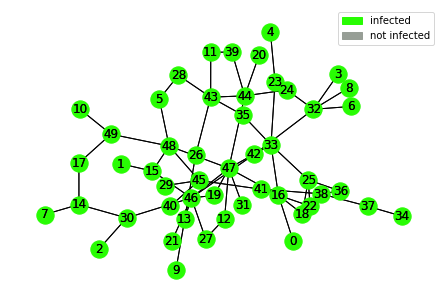

In [56]:
experiment.visualize()

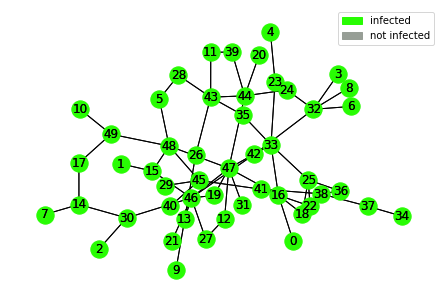

In [57]:
experiment1.visualize()

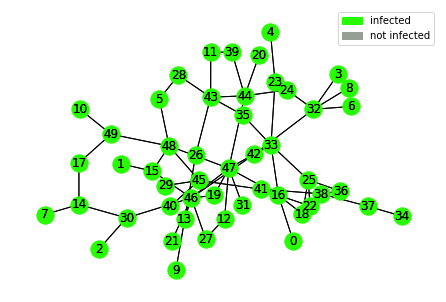

In [58]:
experiment2.visualize()

In [59]:
print(CELF(G,penalty_reduction, cost, 3))

{41, 3, 15}
